In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,RandomizedSearchCV,cross_val_score
from sklearn.preprocessing import LabelEncoder

from math import sqrt
import pickle 

In [2]:
data = pd.read_csv('insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
print("train shape {} rows, {} columns".format(*data.shape))

train shape 1338 rows, 7 columns


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
age         1338 non-null int64
sex         1338 non-null object
bmi         1338 non-null float64
children    1338 non-null int64
smoker      1338 non-null object
region      1338 non-null object
charges     1338 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [6]:
data.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [7]:
# looking for missing value
null_columns=data.columns[data.isnull().any()]
data[null_columns].isnull().sum()

Series([], dtype: float64)

NO MISSING VALUE GREAT!!!

# Data Visualization

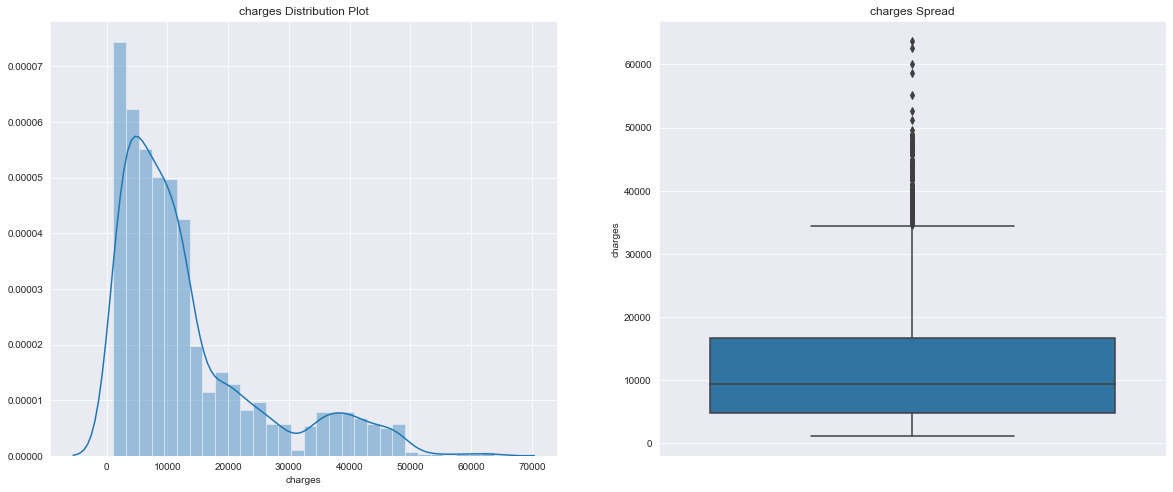

In [8]:
#data visualization of the target var
plt.figure(figsize=(20,8))
sb.set_style('darkgrid')
plt.subplot(1,2,1)
plt.title('charges Distribution Plot')
sb.distplot(data.charges)

plt.subplot(1,2,2)
plt.title('charges Spread')
sb.boxplot(y=data.charges)

plt.show()

the target variable is a weibull distribution lets visualized the skewness and kurtosis value

In [9]:
from scipy.stats import skew,kurtosis
#skewness and kurtosis
print("Skewness: " + str(data.charges.skew()))
print("Kurtosis: " + str(data.charges.kurt()))

Skewness: 1.5158796580240388
Kurtosis: 1.6062986532967907


A skewness and the kurtosis are greater than 1, then the target data is highly shewed and the kurtosis has heavier tails. 
The kurtosis is greater which means we have so many outlier in our target variable.

In [10]:
# OBSERVE THE TARGET VARIABLE 
data['charges'].describe()

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

In [11]:
data['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

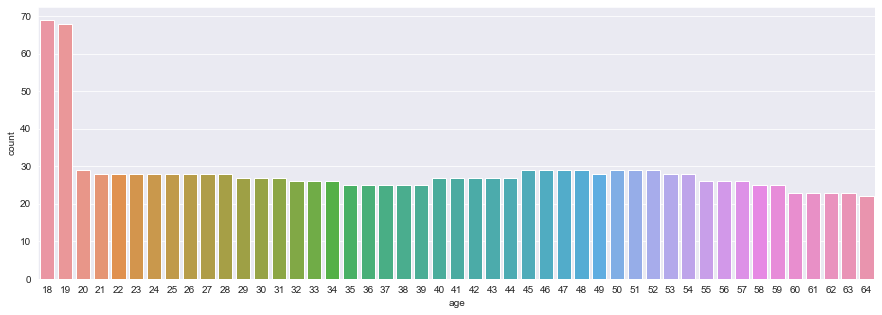

In [12]:
# Smoker
plt.figure(figsize=(15,5))
sb.countplot(data.age)
plt.show()

Most clients are teenagers

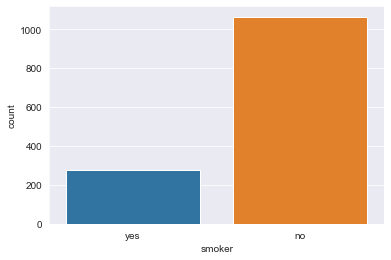

In [13]:
# Smoker
sb.countplot(data.smoker)

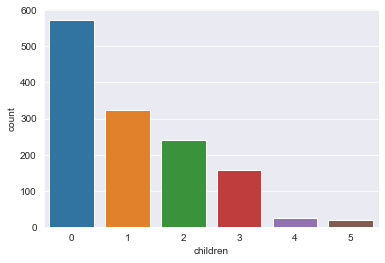

In [14]:
# Children
sb.countplot(data.children)

Most client doesnt have children

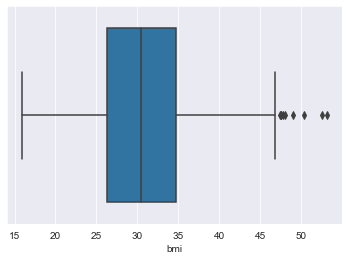

In [15]:
# outliers in bmi 
sb.boxplot(data.bmi)

Bmi has some outliers here but this cant affect the prediction, so let's move on!

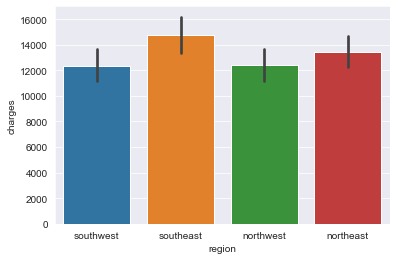

In [16]:
sb.barplot(data.region,data.charges)

Text(0.5, 1.0, 'Distribution of charges by number of children')

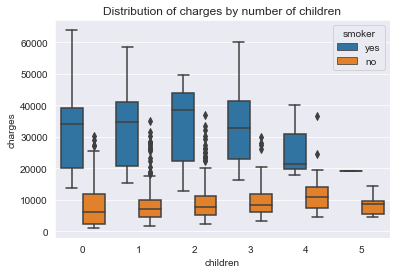

In [17]:
sb.boxplot(x = "children", y = "charges",hue = "smoker", data = data)
plt.title("Distribution of charges by number of children")

There seems to be a charges threshold. Smokers generally make claims with minimum amount of approximately 15000 regardless of number of children whereas non-smokers make a maximum claim of 20000 (typically below 15000).

Smoking is definitely an important feature to take note in modelling.

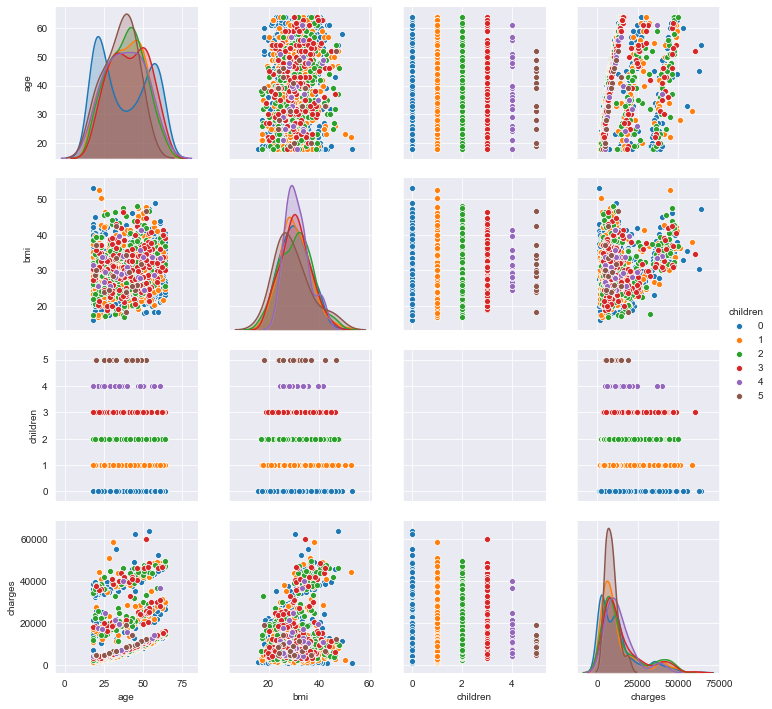

In [18]:
sb.pairplot(data,hue='children')

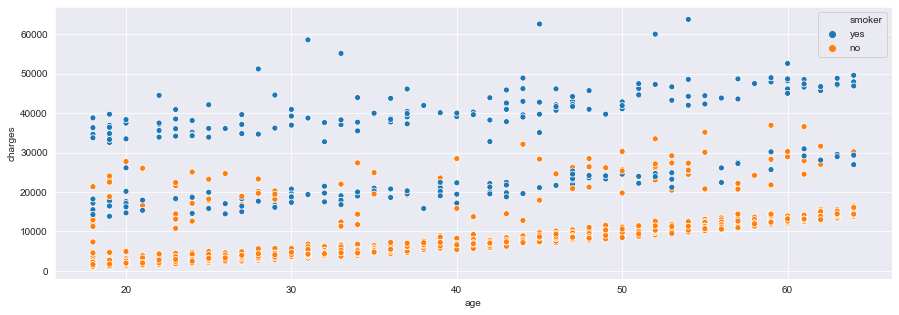

In [19]:
plt.figure(figsize=(15, 5))
sb.scatterplot(data.age,data.charges, hue='smoker',data=data)
plt.show()

From the picture above, we can see that most client with low charges are Non-Smokers while the ones that has a high charges are smokers and the charge increase with respect to age

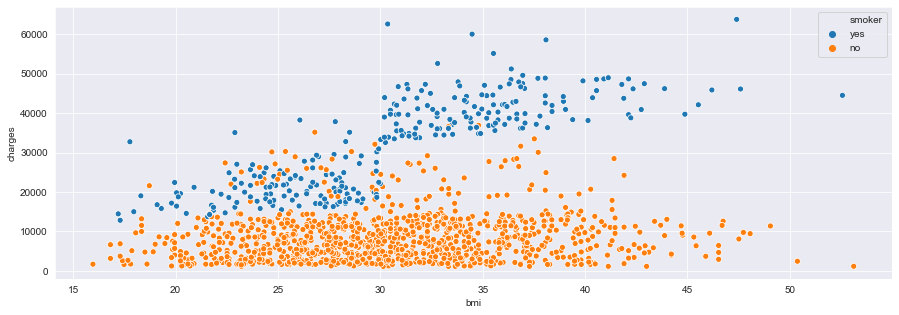

In [20]:
plt.figure(figsize=(15, 5))
sb.scatterplot(data.bmi,data.charges, hue='smoker',data=data)
plt.show()

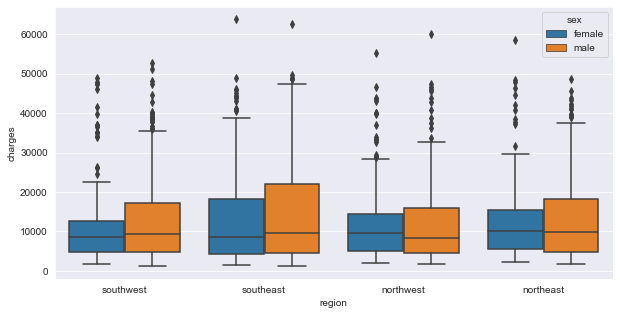

In [21]:
plt.figure(figsize = (10,5))
sb.boxplot(x = "region", y = "charges", hue = "sex", data = data)

Across south west, north west and north east, the charges are rather similar. However, individuals from south east has a wider range of charges for both sexes. Each individual should be categorized as either from southeast or not from southeast region.

In [22]:
# data=data.drop(columns=['region','bmi','sex'],axis=1)

In [23]:
# list the categorical variables
cat_var=data.select_dtypes(include=['object']).columns
print(cat_var)

Index(['sex', 'smoker', 'region'], dtype='object')


In [24]:
# ## Deleting those some outliers. 
previous_data = data.copy()
data = data[data.charges < 50000]
data.reset_index(drop = True, inplace = True)


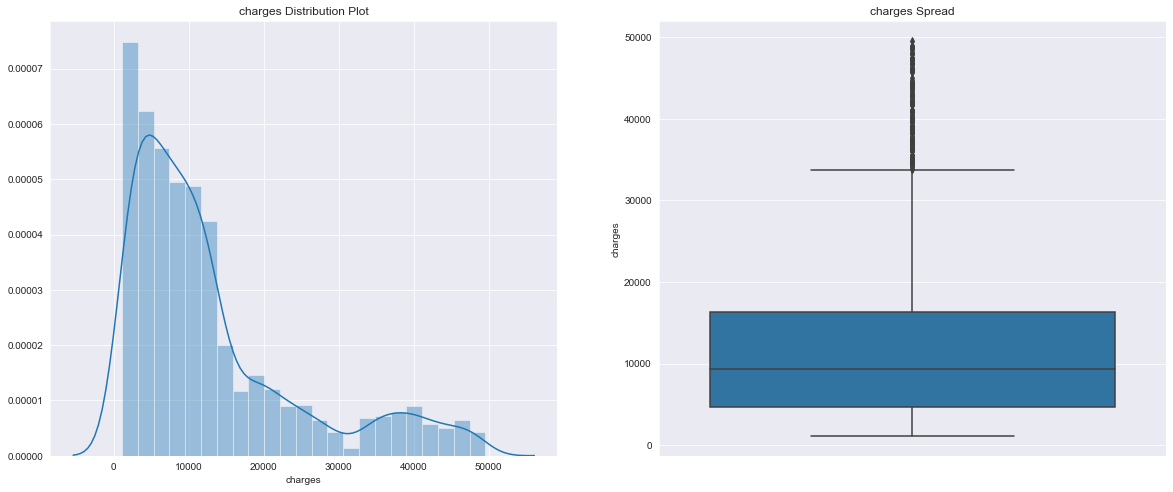

In [25]:
# lets look for outliers
#data visualization
plt.figure(figsize=(20,8))
sb.set_style('darkgrid')
plt.subplot(1,2,1)
plt.title('charges Distribution Plot')
sb.distplot(data.charges)

plt.subplot(1,2,2)
plt.title('charges Spread')
sb.boxplot(y=data.charges)

plt.show()

In [26]:
from scipy.stats import skew,kurtosis
#skewness and kurtosis
print("Skewness: " + str(data.charges.skew()))
print("Kurtosis: " + str(data.charges.kurt()))

Skewness: 1.4525577790709243
Kurtosis: 1.2640854013364096


In [27]:

labelencoder_X = LabelEncoder()
data['sex'] = labelencoder_X.fit_transform(data['sex'])
data['smoker'] = labelencoder_X.fit_transform(data['smoker'])
data['region'] = labelencoder_X.fit_transform(data['region'])

In [28]:
data

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520
...,...,...,...,...,...,...,...
1326,50,1,30.970,3,0,1,10600.54830
1327,18,0,31.920,0,0,0,2205.98080
1328,18,0,36.850,0,0,2,1629.83350
1329,21,0,25.800,0,0,3,2007.94500


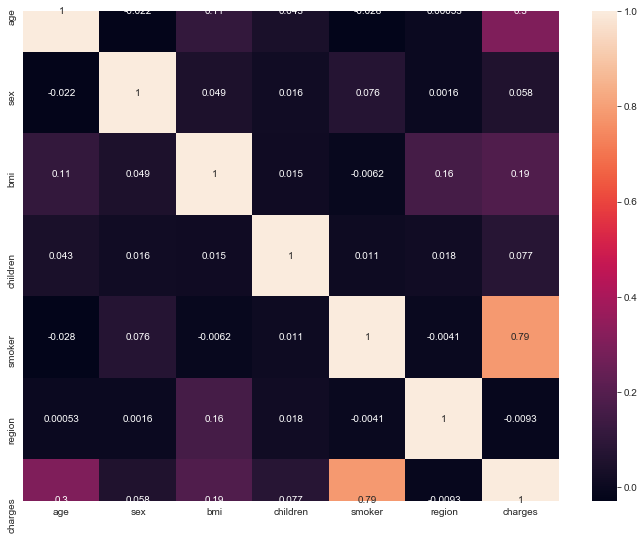

In [29]:
plt.figure(figsize=(12, 9))
sb.heatmap(data.corr(),annot=True)

In [30]:
## Getting the correlation of all the features with target variable(charges). 
(data.corr()**2)["charges"].sort_values(ascending = False)[1:]

smoker      0.617194
age         0.092757
bmi         0.034992
children    0.005928
sex         0.003308
region      0.000087
Name: charges, dtype: float64

# MODEL 

In [31]:
# Spliting the datasewt
X=data[data.columns.drop('charges')]
y=data['charges']

In [32]:
# splitting the dataset into training and test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [33]:
# lookin for the best parameters 

regressor = RandomForestRegressor(random_state=42)
param_grid ={'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
            }
CV_rfc = RandomizedSearchCV(estimator=regressor, param_distributions = param_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
CV_rfc.fit(X_train, y_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.6min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [34]:
params=CV_rfc.best_params_

In [35]:
# Fitting Random Forest Regression to the dataset

regressor = RandomForestRegressor(**params)
regressor.fit(X_train, y_train)

# Predicting the Test set results
y_pred = regressor.predict(X_test)

# Predicting the training set result
y_train_pred = regressor.predict(X_train)

In [36]:

print("R2 score on the test set:",r2_score(y_test, y_pred)*100)
print("R2 score on the training set:",r2_score(y_train, y_train_pred)*100)

R2 score on the test set: 86.96559269586133
R2 score on the training set: 91.38139292619441


In [37]:

print("RMSE score on the test set:",sqrt(mean_squared_error(y_test, y_pred)))
print("RMSE score on the training set:",sqrt(mean_squared_error(y_train, y_train_pred)))

RMSE score on the test set: 4441.822157979101
RMSE score on the training set: 3348.3888290212094


In [38]:
accuracies = cross_val_score(estimator=regressor, X=X_train, y=y_train, cv=10)
print(accuracies.mean(), accuracies.std())

0.8400725205801075 0.05068261763913528


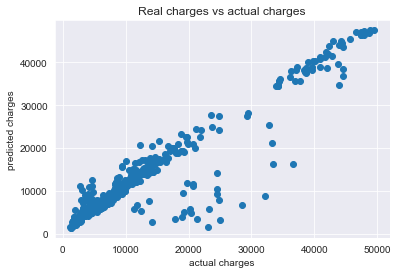

In [39]:
# # visualizing between the actual and the predicted charges on the test set
plt.scatter(y_test,y_pred)
plt.xlabel('actual charges')
plt.ylabel('predicted charges')
plt.title('Real charges vs actual charges')
plt.show()

# MODEL TESTING

In [40]:
# To save the sterialized model
pickle.dump(regressor,open('model.pkl','wb'))

In [41]:
# load/deserialized model to make future prediction
# model=pickle.load(open("model.pkl",'rb'))
# print(model.predict([[19,0,28,0,1,1]]))